In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:

from __future__ import print_function
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as td
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.utils.data import DataLoader
from IPython.display import HTML
from torchvision.io import read_image
import torchvision.models as models
import torch.nn.init as init
import torch.nn.functional as F
import pickle
import cv2
import numpy as np
from PIL import Image
import dlib
import sys
from matplotlib import pyplot as plt
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

--2023-05-05 21:25:18--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.251.69, 52.84.251.32, 52.84.251.108, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.251.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   251MB/s    in 1.4s    

2023-05-05 21:25:21 (251 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 1.75 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
!ls

drive  ffhq.pkl  sample_data  stylegan2-ada-pytorch


In [ ]:
%cd stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [ ]:
!ls

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


In [ ]:
# load the model from disk
loaded_model = pickle.load(open('/content/ffhq.pkl', 'rb'))
print(loaded_model)

{'G': Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): Ful

In [ ]:
!python3 generate.py --outdir=out --trunc=1 --seeds=85,265,297,849,851,665,300,800,90,270 \
    --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

# Question 2

Using StyleGAN2

In [37]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

In [67]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)


Saving source_img.jpeg to source_img.jpeg


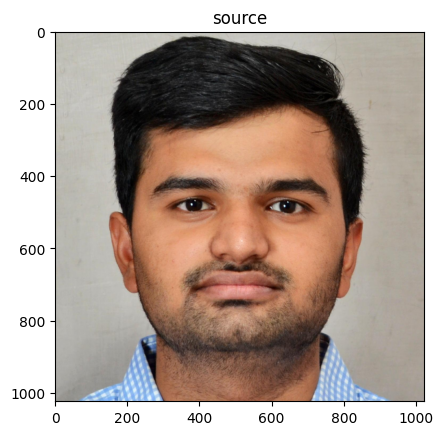

In [71]:
image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")


cropped_source = crop_stylegan(image_source)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()



For Target Image 1

In [69]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving seed0085.png to seed0085.png


In [70]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)

(1322, 930) (1369, 977)
(1184, 930) (1231, 977)
(837, 924) (884, 971)
(976, 927) (1023, 974)
(1077, 1143) (1124, 1190)


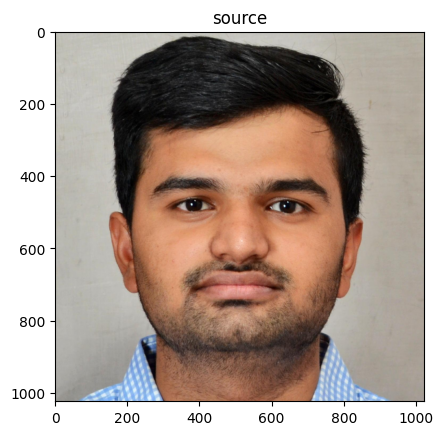

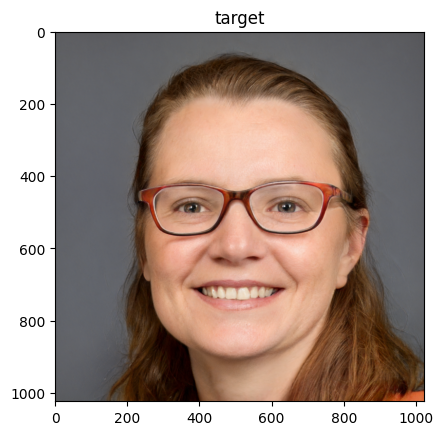

True

In [72]:


image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

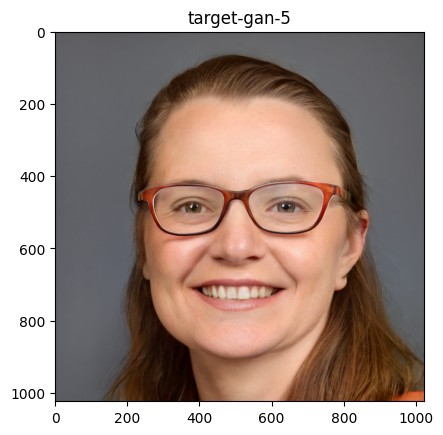

In [77]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'target-gan-{i+1}')
plt.show()

In [79]:
lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
  
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()
from google.colab import files
files.download(f"movie.mp4")

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

For Target Image 2

Saving shukla.jpg to shukla.jpg
(1322, 930) (1369, 977)
(1184, 930) (1231, 977)
(837, 924) (884, 971)
(976, 927) (1023, 974)
(1077, 1143) (1124, 1190)


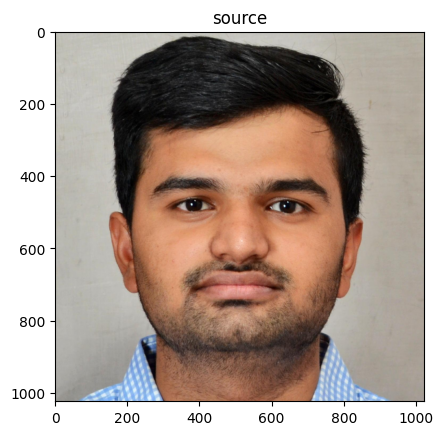

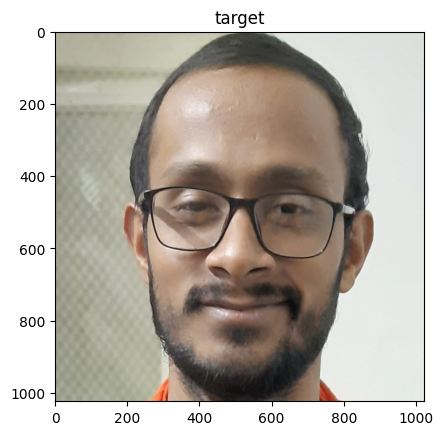

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.68 loss 24567.34
step    2/1000: dist 0.59 loss 27640.57
step    3/1000: dist 0.67 loss 27166.79
step    4/1000: dist 0.59 loss 26253.39
step    5/1000: dist 0.61 loss 24957.22
step    6/1000: dist 0.71 loss 23352.25
step    7/1000: dist 0.64 loss 21510.79
step    8/1000: dist 0.60 loss 19486.88
step    9/1000: dist 0.61 loss 17341.54
step   10/1000: dist 0.59 loss 15140.38
step   11/1000: dist 0.60 loss 12947.

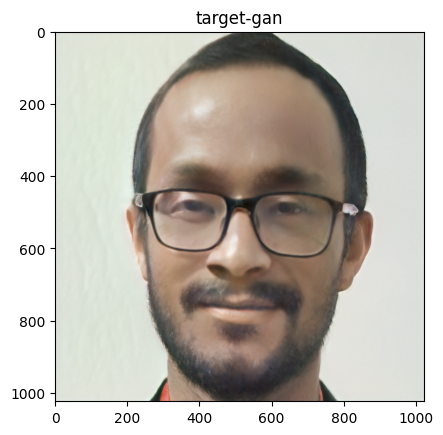

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)


img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)




image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)


cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}


img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'target-gan')
plt.show()



lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
  
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()
from google.colab import files
files.download(f"movie.mp4")

## For Image 3

Saving Apoorv.jpg to Apoorv.jpg
(1322, 930) (1369, 977)
(1184, 930) (1231, 977)
(837, 924) (884, 971)
(976, 927) (1023, 974)
(1077, 1143) (1124, 1190)


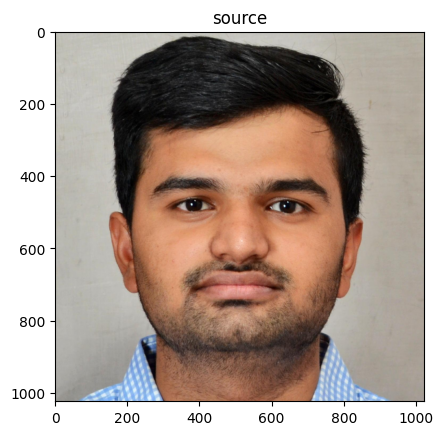

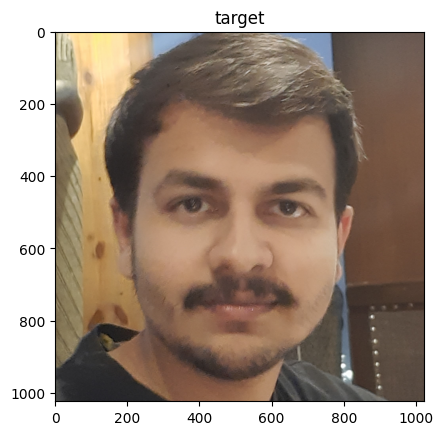

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.58 loss 24567.24
step    2/1000: dist 0.63 loss 27640.61
step    3/1000: dist 0.62 loss 27166.74
step    4/1000: dist 0.55 loss 26253.35
step    5/1000: dist 0.60 loss 24957.21
step    6/1000: dist 0.61 loss 23352.15
step    7/1000: dist 0.58 loss 21510.74
step    8/1000: dist 0.57 loss 19486.84
step    9/1000: dist 0.59 loss 17341.53
step   10/1000: dist 0.57 loss 15140.36
step   11/1000: dist 0.57 loss 12947.

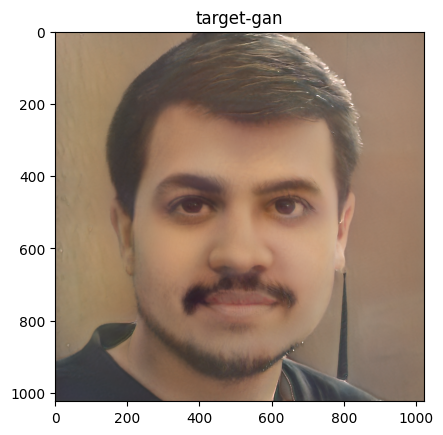

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)


img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)




image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)


cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}


img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'target-gan')
plt.show()



lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
  
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()
from google.colab import files
files.download(f"movie.mp4")

For Image 4

Saving ashish.jpg to ashish.jpg
(1322, 930) (1369, 977)
(1184, 930) (1231, 977)
(837, 924) (884, 971)
(976, 927) (1023, 974)
(1077, 1143) (1124, 1190)


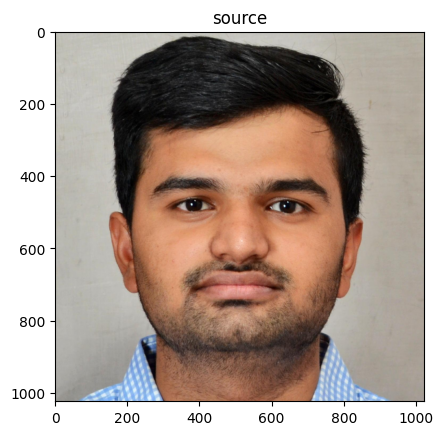

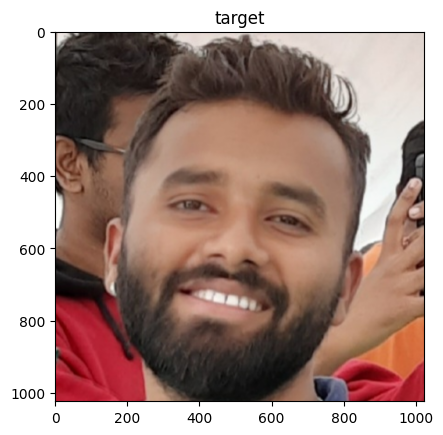

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.60 loss 24567.26
step    2/1000: dist 0.71 loss 27640.69
step    3/1000: dist 0.67 loss 27166.79
step    4/1000: dist 0.57 loss 26253.37
step    5/1000: dist 0.60 loss 24957.21
step    6/1000: dist 0.60 loss 23352.14
step    7/1000: dist 0.57 loss 21510.72
step    8/1000: dist 0.58 loss 19486.85
step    9/1000: dist 0.61 loss 17341.55
step   10/1000: dist 0.58 loss 15140.37
step   11/1000: dist 0.56 loss 12947.

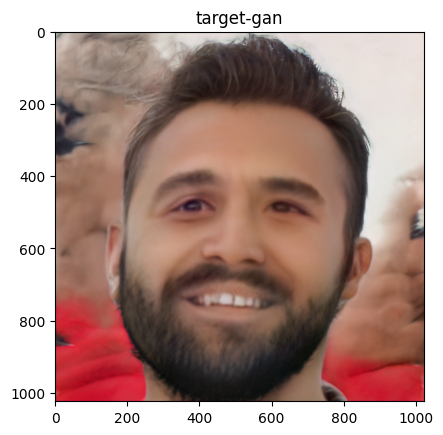

  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)


img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)




image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)


cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}


img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'target-gan')
plt.show()



lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
  
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()
from google.colab import files
files.download(f"movie.mp4")